# MLP Approach 

![Example Image](../images/bengio-model.png)

In [187]:
import torch
import torch.nn.functional as F

import random

import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
# Loading data
words = open("../data/indian_names.txt", 'r').read().splitlines()
len(words)

6474

In [43]:
# Building Vocabulary and Conversions   str <--> int
chrs = sorted(list(set(''.join(words))))

stoi = {s : i+1 for i, s in enumerate(chrs)}
itos = {i+1 : s for i, s in enumerate(chrs)}

stoi['.'] = 0
itos[0] = '.'

special_characters = ['.']

chrs = sorted(chrs + special_characters)

In [49]:
# Building the dataset

block_size = 3          # Context Length! How many characters to take to predict the next one
X, Y = [], []

for word in words[:5]:
    #print(''.join(word))
    context = [0] * block_size
    for ch in word + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, Y.shape

(torch.Size([33, 3]), torch.Size([33]))

In [50]:
# Embedding table
embid_size = 2
C = torch.randn((len(chrs), embid_size))
emb = C[X]
emb.shape

torch.Size([33, 3, 2])

In [52]:
# Hidden layer
num_hidden = 128

w1 = torch.randn((block_size*embid_size, num_hidden))
b1 = torch.randn((128))

# emb @ w1 + b1
h = torch.tanh(emb.view((-1, emb.shape[1]*emb.shape[2])) @ w1 + b1)      # Keep the same dimensions
h.shape


torch.Size([33, 128])

In [59]:
# Final layer
w2 = torch.randn((num_hidden, len(chrs)))
b2 = torch.randn(len(chrs))

logits = h @ w2 + b2            # Shape [batch_size, vocab]

'''
Cross entropy is used for classification problems. It takes in logits and targets as inputs.
Internally it calculates the softmax, to get probabilities and then takes the correct prob value we want,
it logs it, and calculate the mean and negating it. So basically calculating negative log likelihood dirextly from logits and targets. Much efficient.
'''

loss = F.cross_entropy(logits, Y)
loss.item()

20.055004119873047

## Bringing it all together!!

In [274]:
# Imports
import torch
import torch.nn.functional as F

import random

import matplotlib.pyplot as plt
%matplotlib inline

In [286]:
# Hyperparaeters
block_size = 5          # Context Length! How many characters to take to predict the next one
embid_size = 15          # How many dimension in the embedding space
batch_size = 256
num_hidden = 256        # Number of neurons in the hidden layer
lr = 0.05
epochs = 50000

In [287]:
# Dataset

train_split = 0.8
dev_split = 0.1
test_split = 0.1

assert (train_split + dev_split + test_split) == 1.0, "Data Split ration does not add up to 1.0"

# Loading data
words = open("../data/indian_names.txt", 'r').read().splitlines()
print(len(words), "words.")

# Building Vocabulary and Conversions   str <--> int
chrs = sorted(list(set(''.join(words))))
stoi = {s : i+1 for i, s in enumerate(chrs)}
itos = {i+1 : s for i, s in enumerate(chrs)}

stoi['.'] = 0
itos[0] = '.'

special_characters = ['.']
chrs = sorted(chrs + special_characters)

# Takes some words and builds X and Y data out of it
def build_dataset(words, type = 'train'):
    
    X, Y = [], []

    for word in words:
        #print(''.join(word))
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"Shape of {type} data is     X -> {X.shape}      Y ->  {Y.shape}")

    return X, Y

# Shuffling the data
random.seed(800)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# Calling build
Xtrain, Ytrain = build_dataset(words[:n1], "train")
Xdev, Ydev = build_dataset(words[n1:n2], "dev")
Xtest, Ytest = build_dataset(words[n2:], "test")

6474 words.
Shape of train data is     X -> torch.Size([38221, 5])      Y ->  torch.Size([38221])
Shape of dev data is     X -> torch.Size([4691, 5])      Y ->  torch.Size([4691])
Shape of test data is     X -> torch.Size([4705, 5])      Y ->  torch.Size([4705])


In [288]:
# Weights initializing
g = torch.Generator().manual_seed(800)

C = torch.randn((len(chrs), embid_size), generator=g)

w1 = torch.randn((block_size*embid_size, num_hidden), generator=g)
b1 = torch.randn((num_hidden), generator=g)

w2 = torch.randn((num_hidden, len(chrs)), generator=g)
b2 = torch.randn(len(chrs), generator=g)

parameters = [C, w1, b1, w2, b2]

In [289]:
# Checking parameters
for p in parameters:
    p.requires_grad = True
print("Total parameters to train -->", sum(p.nelement() for p in parameters))

Total parameters to train --> 26800


In [290]:
# Accumulation storage
loss_track = []
lr_track = []

lre = torch.linspace(-3, 0, epochs)
lrs = 10**lre

In [293]:
# Training Loop

for epoch in range(epochs):

    # Batch creation
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,))

    # Forward Pass
    emb = C[Xtrain[ix]]      # Shape [batch_dim, block_dim, emb_dim]
    h = torch.tanh(emb.view((-1, emb.shape[1]*emb.shape[2])) @ w1 + b1)
    logits = h @ w2 + b2            # Shape [batch_size, vocab]
    loss = F.cross_entropy(logits, Ytrain[ix])

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    # lr = lrs[epoch]
    lr = 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # Statistics
    if epoch % 1000 == 0:
        print(f'{epoch=} and {loss.item()=}')

    # Accumulate
    loss_track.append(loss.log10().item())
    lr_track.append(lr)

epoch=0 and loss.item()=1.9923968315124512
epoch=1000 and loss.item()=1.9392573833465576
epoch=2000 and loss.item()=2.0310239791870117
epoch=3000 and loss.item()=1.9862635135650635
epoch=4000 and loss.item()=2.002941131591797
epoch=5000 and loss.item()=1.9475618600845337
epoch=6000 and loss.item()=1.9938814640045166
epoch=7000 and loss.item()=1.968012809753418
epoch=8000 and loss.item()=1.752557635307312
epoch=9000 and loss.item()=1.8278521299362183
epoch=10000 and loss.item()=1.786801815032959
epoch=11000 and loss.item()=1.8535842895507812
epoch=12000 and loss.item()=2.0132927894592285
epoch=13000 and loss.item()=1.8488523960113525
epoch=14000 and loss.item()=1.988520860671997
epoch=15000 and loss.item()=1.997864007949829
epoch=16000 and loss.item()=1.9327415227890015
epoch=17000 and loss.item()=2.0087122917175293
epoch=18000 and loss.item()=1.927246332168579
epoch=19000 and loss.item()=1.8898320198059082
epoch=20000 and loss.item()=1.896616816520691
epoch=21000 and loss.item()=1.8703

In [294]:
# Calculating loss for the entire dataset

# Forward Pass
emb = C[Xdev]      # Shape [batch_dim, block_dim, emb_dim]
h = torch.tanh(emb.view((-1, emb.shape[1]*emb.shape[2])) @ w1 + b1)
logits = h @ w2 + b2            # Shape [batch_size, vocab]
loss = F.cross_entropy(logits, Ydev)

print("Overall Loss on dev set is -->", loss.item())

Overall Loss on dev set is --> 2.2163844108581543


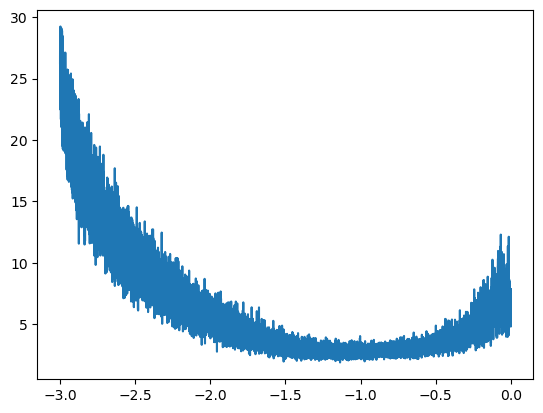

In [243]:
# Plotting the lr vs loss
plt.plot(lre, loss_track)

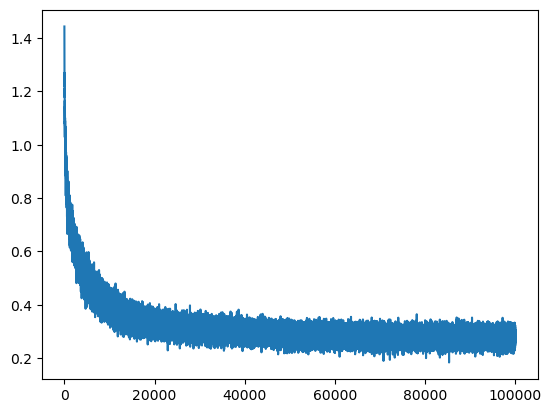

In [295]:
# Plotting the loss vs epochs
plt.plot(range(len(loss_track)), loss_track)

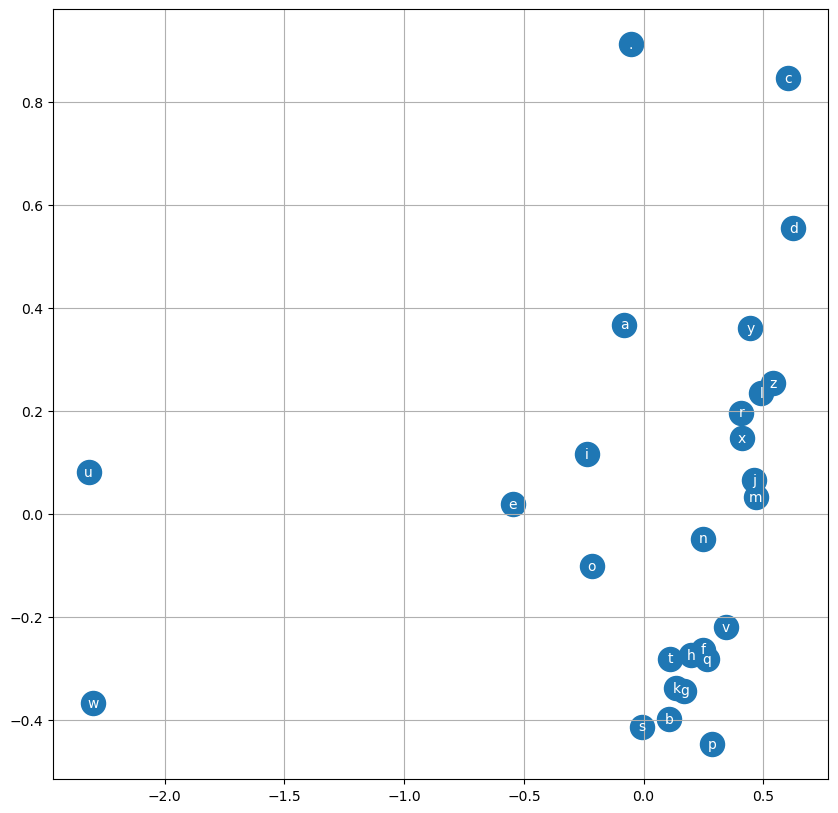

In [231]:
# Visualizing the EMbedding space
plt.figure(figsize = (10, 10))
plt.scatter(C[:, 0].data, C[:, 1].data, s = 300)
for i in range(C.shape[0]):
    st = itos[i]
    plt.text(C[i, 0], C[i, 1], st, ha="center", va="center", color="white")
plt.grid('both')

In [307]:
# Sample from the model
g = torch.Generator().manual_seed(900)

num_names = 20
names = []

for i in range(num_names):

    name = ""
    context = [0] * block_size

    while True:
        # forward pass
        emb = C[torch.tensor([context])]        # [1, block_size, emb_size]
        h = torch.tanh(emb.view((-1, emb.shape[1]*emb.shape[2])) @ w1 + b1)
        logits = h @ w2 + b2            # Shape [batch_size, vocab]
        probs = F.softmax(logits, dim = 1)
        # sample from this dist
        ix = torch.multinomial(probs, num_samples = 1, replacement = True).item()
        context = context[1:] + [ix]
        # break and save because end of word
        if itos[ix] == '.':
            names.append(name)
            break
        # store characters
        name = name + itos[ix]

names

['preela',
 'dhvad',
 'rudekhar',
 'diravi',
 'rakisha',
 'seha',
 'sana',
 'gunundansha',
 'abhiar',
 'arnooc',
 'beerajpal',
 'saran',
 'ahayj',
 'deepankaj',
 'premti',
 'tuusma',
 'antrasthas',
 'somsina',
 'rumjan',
 'mushim']